In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from imutils import contours
from imutils.perspective import four_point_transform


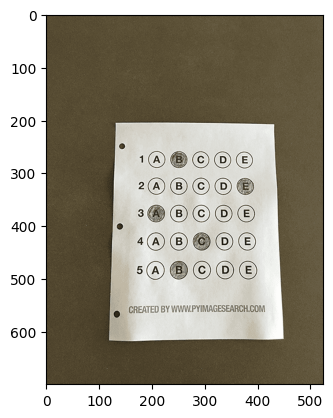

In [43]:
image = cv2.imread('images/omr2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

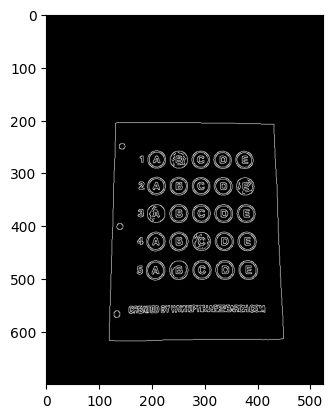

In [16]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)
plt.imshow(edged, cmap="gray")

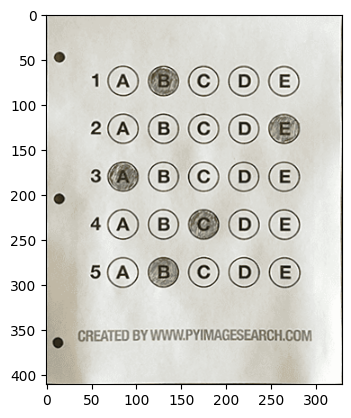

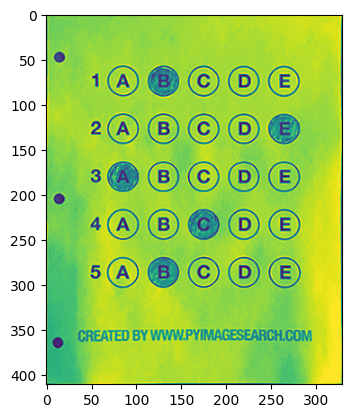

In [17]:

cnts = cv2.findContours(edged.copy(), mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in
    # descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break
            
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))
plt.imshow(paper)
plt.show()
plt.imshow(warped)
plt.show()

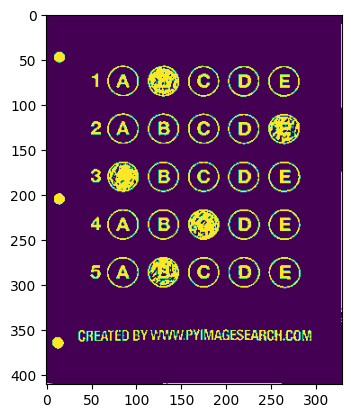

In [18]:
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
plt.show()

25


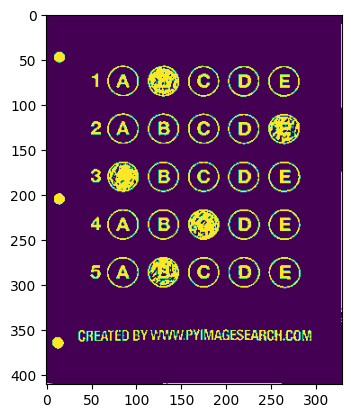

In [40]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []
thres_copy = thresh.copy()
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)
        # cv2.rectangle(thres_copy, (x, y), (x + w, y + h), (36,255,12), 5)
print(len(questionCnts))
plt.imshow(thres_copy,)
plt.show()

[1, 4, 0, 2, 1]
[1, 4, 0, 2, 1]


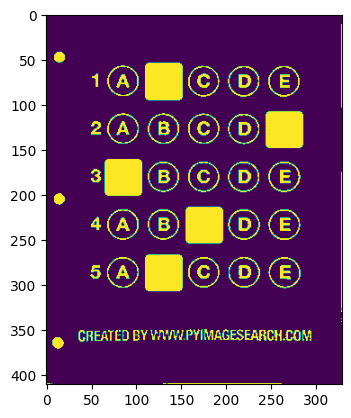

In [44]:

correct_answer = [1,4,0,2,1]
correct_guessed = []

questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    cnts = imutils.contours.sort_contours(questionCnts[i:i+5])
    # loop over the sorted contours
    cnts = imutils.grab_contours(cnts)
    max_nonzero = 0
    max_loc = 0
    for (j, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        #plt.imshow(thresh[y:y+h, x:x+w])
        #plt.show()
        non_zero = np.count_nonzero(thresh[y:y+h, x:x+w])
        #print((x, y, w, h))
        if non_zero > max_nonzero:
            max_nonzero = non_zero
            max_loc = j
            dim = (x, y, w, h) # Saving the max dimension
    cv2.rectangle(thres_copy, (dim[0], dim[1]), (dim[0] + dim[2], dim[1] + dim[3]), (255,255,0), -1)
    correct_guessed.append(max_loc)


plt.imshow(thres_copy)
print(correct_answer)
print(correct_guessed)

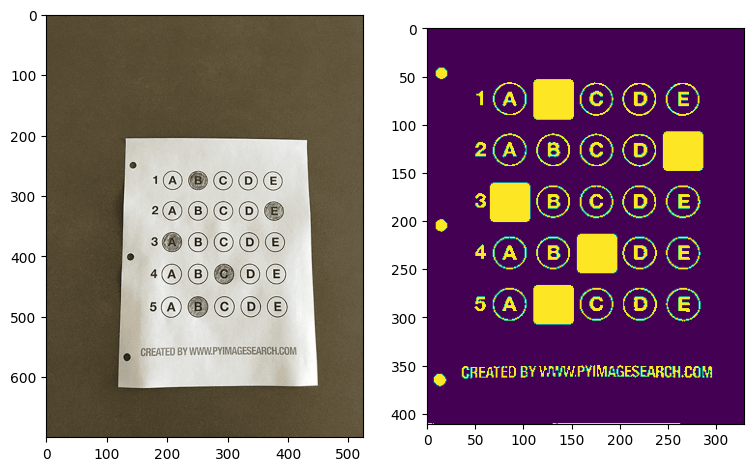

In [52]:
f, axarr = plt.subplots(1,2, figsize=(9, 9))
axarr[0].imshow(image)
axarr[1].imshow(thres_copy)